<a href="https://colab.research.google.com/github/sokistar24/Track/blob/master/Behavioral_cloning_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 37.18 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [2]:
!ls track

driving_log.csv  IMG


In [3]:
!pip3 install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.layers import Convolution2D,Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [5]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

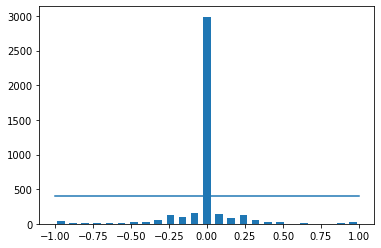

In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [7]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
 
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2018_07_16_17_11_43_670.jpg
left        left_2018_07_16_17_11_43_670.jpg  
right       right_2018_07_16_17_11_43_670.jpg 
steering    0                                 
throttle    0                                 
reverse     0                                 
speed       0.627942                          
Name: 1, dtype: object


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 9727
Valid Samples: 2432


Single Camera Mode

In [9]:
X_train_one, X_valid_one, y_train_one, y_valid_one = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train_one), len(X_valid_one)))

Training Samples: 9727
Valid Samples: 2432


Text(0.5, 1.0, 'Validation set')

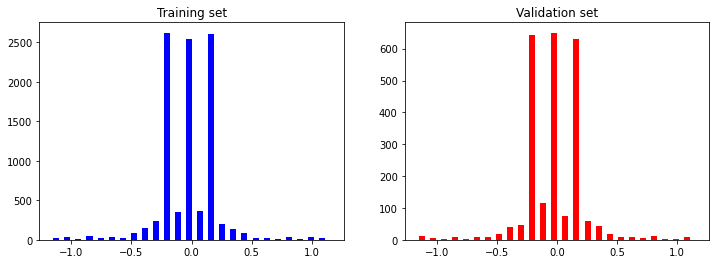

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

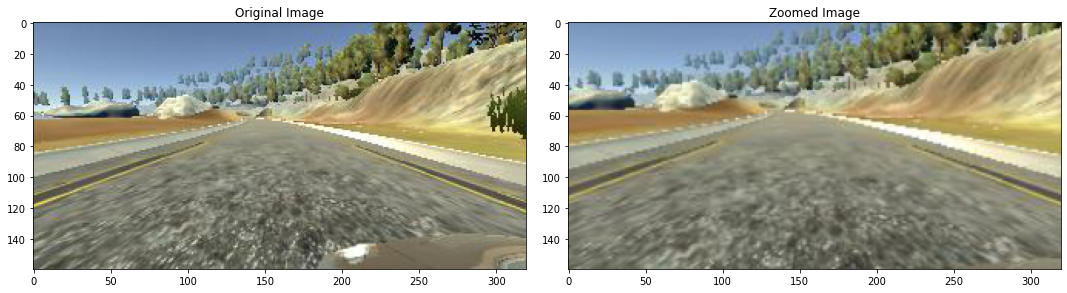

In [11]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [12]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned Image')

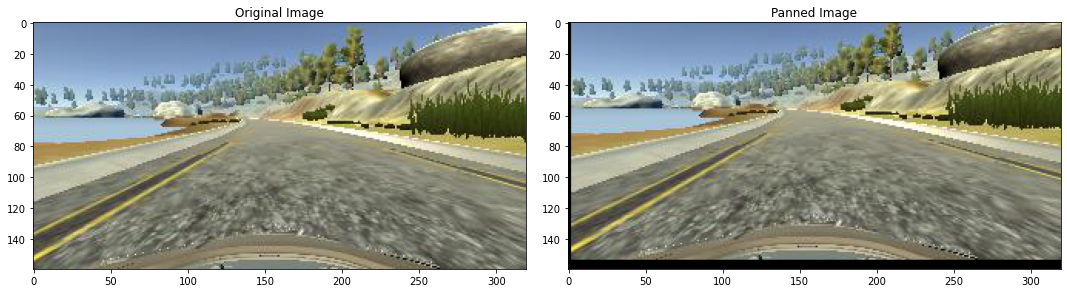

In [13]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [14]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness altered image ')

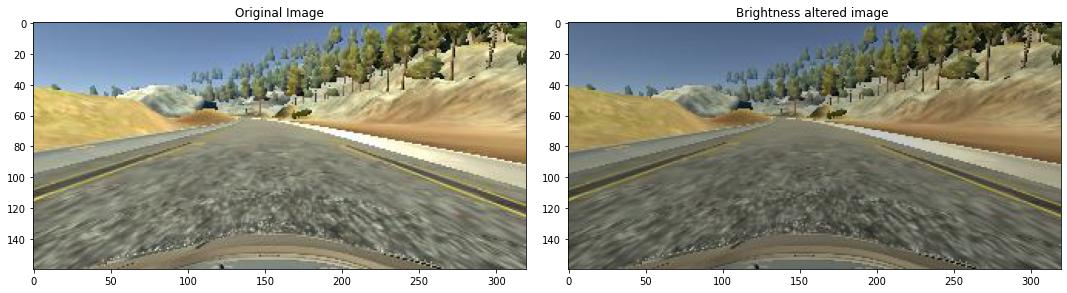

In [15]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

In [16]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

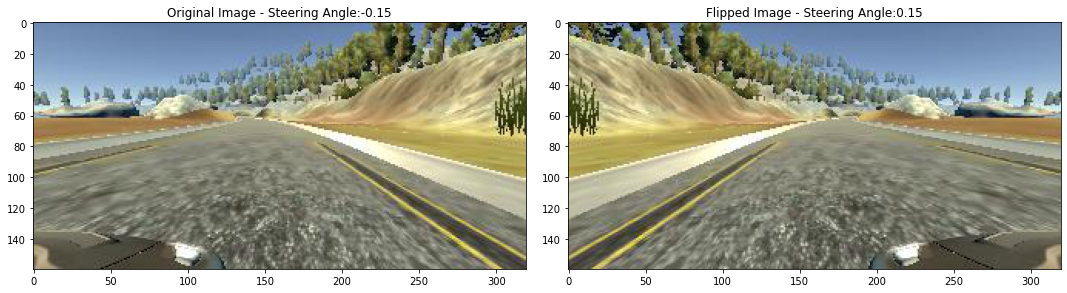

In [17]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [18]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

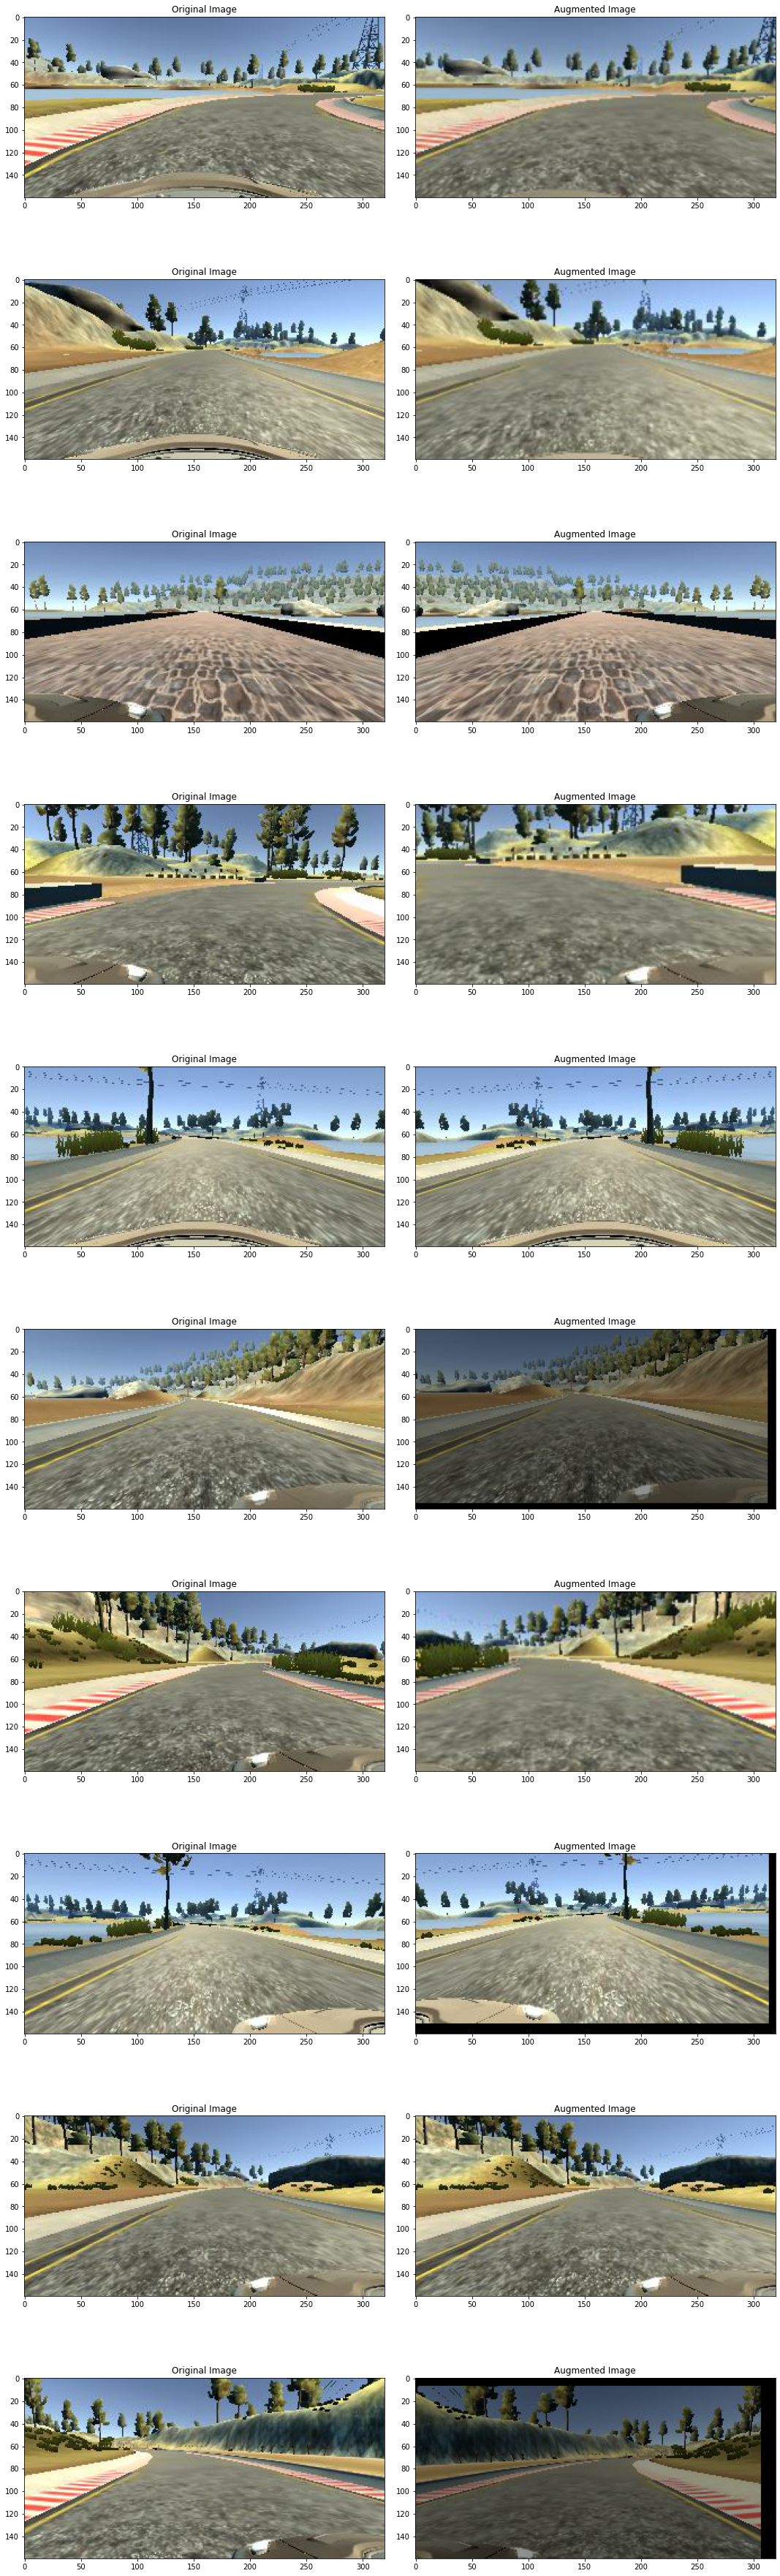

In [19]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Text(0.5, 1.0, 'Preprocessed Image')

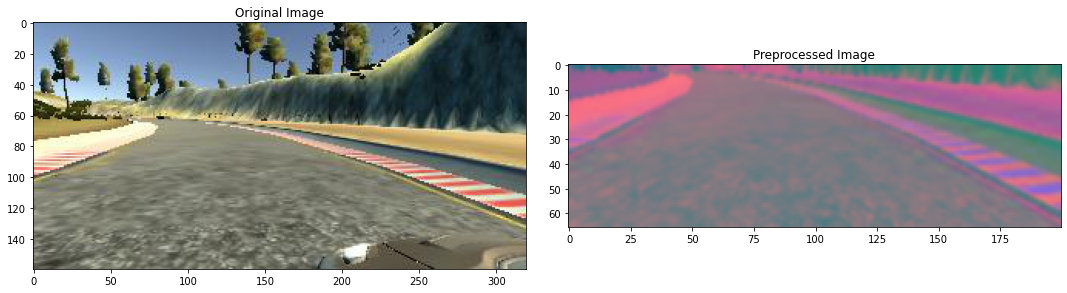

In [20]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [21]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

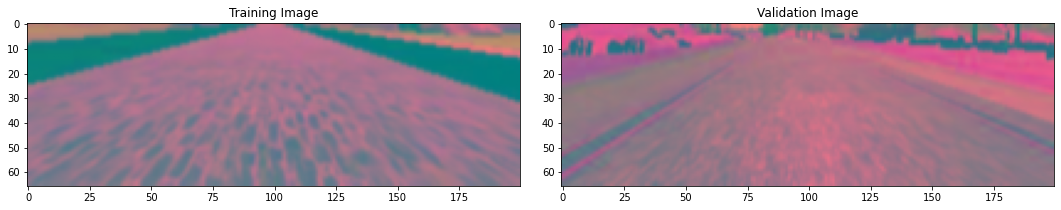

In [22]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

for one camera batch generator

In [23]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
 
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  #model.add(Dropout(0.5))
  
  
  model.add(Flatten())
  
  model.add(Dense(100, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(50, activation = 'elu'))
  #model.add(Dropout(0.5))
  
  model.add(Dense(10, activation = 'elu'))
  #model.add(Dropout(0.5))
 
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [24]:
 model = nvidia_model()
 print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [25]:
history_nvidia = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
300/300 [==============================] - 183s 610ms/step - loss: 0.7020 - val_loss: 0.0540
Epoch 2/10
300/300 [==============================] - 177s 591ms/step - loss: 0.0602 - val_loss: 0.0730
Epoch 3/10
300/300 [==============================] - 174s 579ms/step - loss: 0.0542 - val_loss: 0.0529
Epoch 4/10
300/300 [==============================] - 176s 586ms/step - loss: 0.0560 - val_loss: 0.0638
Epoch 5/10
300/300 [==============================] - 180s 600ms/step - loss: 0.0534 - val_loss: 0.0529
Epoch 6/10
300/300 [==============================] - 182s 608ms/step - loss: 0.0545 - val_loss: 0.0539
Epoch 7/10
300/300 [==============================] - 183s 611ms/step - loss: 0.0542 - val_loss: 0.0527
Epoch 8/10
300/300 [==============================] - 184s 614ms/step - loss: 0.0525 - val_loss: 0.0523
Epoch 9/10
300/300 [==============================] - 184s 613ms/step - loss: 0.0538 - val_l

In [26]:
#plt.plot(history_main.history['loss'])
#plt.plot(history_nvidia.history['val_loss'])
#plt.legend(['traininng ','validation'])
#plt.title('Loss against epoch')
#plt.ylabel('loss')
#plt.xlabel('epoch')


In [27]:
#model.save('model6.h5')

#from google.colab import files
#files.download('model6.h5')

Transfer Learnng 

In [28]:
vgg=VGG16(input_shape=(66,200,3),weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [29]:
for layer in vgg.layers:
  layer.trainable= False
x=Flatten()(vgg.output)
Dense1=Dense(100,activation='elu')(x)
Dense2=Dense(50,activation='elu')(Dense1)
Dense3=Dense(10,activation='elu')(Dense2)
output=Dense(1)(Dense3)
transfer_model=Model(inputs=vgg.input,outputs=output)
transfer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 66, 200, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 66, 200, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 33, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 33, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 33, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 50, 128)      

In [30]:
transfer_model.compile(loss='mse',optimizer='Adam')

In [31]:
history_main_2 = transfer_model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 196s 653ms/step - loss: 0.1489 - val_loss: 0.0528
Epoch 2/10
300/300 [==============================] - 196s 654ms/step - loss: 0.0425 - val_loss: 0.0346
Epoch 3/10
300/300 [==============================] - 198s 659ms/step - loss: 0.0348 - val_loss: 0.0252
Epoch 4/10
300/300 [==============================] - 197s 658ms/step - loss: 0.0334 - val_loss: 0.0283
Epoch 5/10
300/300 [==============================] - 198s 660ms/step - loss: 0.0305 - val_loss: 0.0247
Epoch 6/10
300/300 [==============================] - 198s 661ms/step - loss: 0.0291 - val_loss: 0.0228
Epoch 7/10
300/300 [==============================] - 196s 652ms/step - loss: 0.0287 - val_loss: 0.0225
Epoch 8/10
300/300 [==============================] - 197s 658ms/step - loss: 0.0270 - val_loss: 0.0239
Epoch 9/10
300/300 [==============================] - 198s 660ms/step - loss: 0.0267 - val_loss: 0.0236
Epoch 10/10
300/300 [==============================] - 195s 651m

transfer learning using ResNet

In [32]:
resnet=ResNet50(input_shape=(66,200,3),weights='imagenet',include_top=False)

94773248/94765736 [==============================] - 0s 0us/step


In [33]:
for layer in resnet.layers:
  layer.trainable= False
x=Flatten()(resnet.output)
Dense1=Dense(100,activation='elu')(x)
Dense2=Dense(50,activation='elu')(Dense1)
Dense3=Dense(10,activation='elu')(Dense2)
#prediction=Dense(1)(x)
resnet_model=Model(inputs=resnet.input,outputs=Dense3)
resnet_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 66, 200, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 72, 206, 3)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 33, 100, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 33, 100, 64)  256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [34]:
optimizer = Adam(lr=1e-3)
resnet_model.compile(loss='mse',optimizer=optimizer)

In [35]:
history_main_3 = resnet_model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 198s 659ms/step - loss: 0.8127 - val_loss: 0.5540
Epoch 2/10
300/300 [==============================] - 198s 659ms/step - loss: 0.5608 - val_loss: 0.5586
Epoch 3/10
300/300 [==============================] - 192s 640ms/step - loss: 0.5066 - val_loss: 0.4756
Epoch 4/10
300/300 [==============================] - 186s 620ms/step - loss: 0.4267 - val_loss: 0.3499
Epoch 5/10
300/300 [==============================] - 186s 620ms/step - loss: 0.2987 - val_loss: 0.2641
Epoch 6/10
300/300 [==============================] - 188s 627ms/step - loss: 0.2550 - val_loss: 0.2523
Epoch 7/10
300/300 [==============================] - 183s 612ms/step - loss: 0.2556 - val_loss: 0.2570
Epoch 8/10
300/300 [==============================] - 185s 615ms/step - loss: 0.2521 - val_loss: 0.2483
Epoch 9/10
300/300 [==============================] - 187s 624ms/step - loss: 0.1170 - val_loss: 0.0494
Epoch 10/10
300/300 [==============================] - 190s 634m

plot section for all three models

Text(0.5, 0, 'epoch')

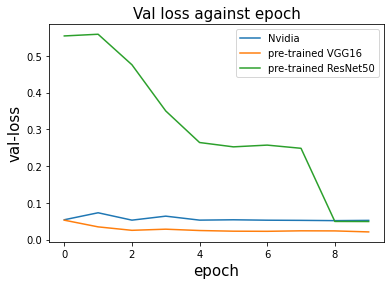

In [40]:
#plt.plot(history_main.history['loss'])
plt.plot(history_nvidia.history['val_loss'])
plt.plot(history_main_2.history['val_loss'])
plt.plot(history_main_3.history['val_loss'])
plt.legend(['Nvidia ','pre-trained VGG16','pre-trained ResNet50'])
plt.title('Val loss against epoch',fontsize=15)
plt.ylabel('val-loss',fontsize=15)
plt.xlabel('epoch',fontsize=15)